Модели и скачивание - мини-библиотеки, моделька - под дз, качалка в какой-то сайдпроект, код либ прилагаю, документацию нет, ибо ее нет)))

In [94]:
import random

import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import pandas as pd

from collections import Counter
from Bio import (
    Entrez,
    SeqIO
)

from mms import install_genomes as ig
from mms import mms as mms
from tqdm.notebook import tqdm_notebook

In [51]:
PART_SIZE = 100000

# Накачаем организмов для теста и модели (ну не вручную же, правда)

Кишечные палки качаются плохо - потому что я скачиваю по DocumentSummarySet, который на них не заводят(. Тут, конечно, можно придраться к технической стороне вопроса, вообще eutils есть, конечно, но ничего страшного - колю найдем руками

In [52]:
orgnames = '''Candidatus Methanoplasma termitum
Cuniculiplasma divulgatum
Ferroplasma acidarmanus fer1
Picrophilus torridus DSM 9790
Thermoplasma acidophilum DSM 1728
Escherichia coli (E. coli)'''

In [53]:
orgnames = orgnames.split('\n')
Entrez.email = "your_email@blank.com"

In [54]:
info = ig.down_org(orgnames, dirname = 'data',
             fasta = True,
             gtf = False,
             gbff = False,
             ft = False,
             proteins = False,
             unzip = True)

/Users/pitikov_egor/Documents/to_karina/mms/install_genomes/src/install_functions.py:49: UserWarning: No DocumentSummarySet for genome Escherichia coli (E. coli). Unable to download
  warnings.warn(f'No DocumentSummarySet for genome {orgname}. Unable to download')


ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/800/805/GCF_000800805.1_ASM80080v1/GCF_000800805.1_ASM80080v1_genomic.fna.gz succefully downloaded
ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/800/805/GCF_000800805.1_ASM80080v1/GCF_000800805.1_ASM80080v1_genomic.fna.gz succefully downloaded
ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/900/083/515/GCF_900083515.1_ASM90008351v1/GCF_900083515.1_ASM90008351v1_genomic.fna.gz succefully downloaded
ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/800/805/GCF_000800805.1_ASM80080v1/GCF_000800805.1_ASM80080v1_genomic.fna.gz succefully downloaded
ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/152/265/GCF_000152265.2_ASM15226v2/GCF_000152265.2_ASM15226v2_genomic.fna.gz succefully downloaded
ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/900/083/515/GCF_900083515.1_ASM90008351v1/GCF_900083515.1_ASM90008351v1_genomic.fna.gz succefully downloaded
ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/152/265/GCF_000152265.2_ASM15226v2/GCF_000152265.2_ASM15226v2_gen

/Users/pitikov_egor/Documents/to_karina/mms/install_genomes/src/install_functions.py:91: UserWarning: Some missing genome can't be downloaded
  warnings.warn('Some missing genome can\'t be downloaded')


In [130]:
o_to_name = {}
here_fastas = 'data'
for i in info:
    if i:
        o_to_name[i.org] = f'{here_fastas}/{i.ass_acc}_{i.ass_name}.fasta'
        
o_to_name['E. coli'] = f'{here_fastas}/GCF_000157115.2.fasta'

Делаем из генома строчку и случайно выбираем участок в 100 килобаз

In [56]:
for rec in SeqIO.parse(o_to_name['E. coli'], 'fasta'):
    genome = rec.seq
    break

In [57]:
genome, len(genome)

(Seq('AATGAACCGTGAGGCTTAACCTTACAACGCCGAAGATGTTTTGGCGGATGAGAG...CAA'), 953648)

In [156]:
strs = []
for i in range(30):
    strs.append(int(random.random()*len(genome)))

In [157]:
def cut_genome(strs, genome = genome, size = PART_SIZE):
    genome = str(genome)
    lg = len(genome)
    for st in strs:
        if st + PART_SIZE >= lg:
            yield genome[st:] + genome[:(lg+st)%lg]
        else:
            yield genome[st:st+PART_SIZE]

In [158]:
genome_parts = cut_genome(strs)

# Ну что, давайте тюнить ММки

In [159]:
table_pars = {'model_depth': [], 
              'AIC': [], 
              'BIC': [], 
              'LnLikelihood': [],
              'GC_context':[], 
              'N_context': []
             }

Просто тюним модели

In [160]:
models = {}
t = 0
for q in tqdm_notebook(it.product(genome_parts, range(0, 6, 1)), desc="Make MMs", total = 180):
    i = q[0]
    d = q[1]
    model = mms.BasicModel(depth = d, pseudocounts = 1)
    i = i.upper()
    fitted = model.fit(i, alphabet = 'ATGCN')
    models[t] = fitted
    t += 1
    i_counter = Counter(i)
    GCcont = i_counter.get('G', 0) + i_counter.get('C', 0) + i_counter.get('g', 0) + i_counter.get('c', 0)
    NAcont = i_counter.get('N', 0) + i_counter.get('n', 0)
    table_pars['model_depth'].append(fitted._depth)
    table_pars['AIC'].append(fitted.aic)
    table_pars['BIC'].append(fitted.bic)
    table_pars['LnLikelihood'].append(fitted.loglikelihood)
    table_pars['GC_context'].append(GCcont)
    table_pars['N_context'].append(NAcont)

Make MMs:   0%|          | 0/180 [00:00<?, ?it/s]

In [161]:
table_pars = pd.DataFrame(table_pars)

Получилась табличка с параметрами

In [162]:
table_pars

,model_depth,AIC,BIC,LnLikelihood,GC_context,N_context
0,0,277057.338550,277104.903178,-138523.669275,51318,0
1,1,413407.958784,413693.346248,-206673.979392,51318,0
2,2,410232.903186,411707.403533,-204961.451593,51318,0
3,3,408633.930457,416053.988920,-203536.965229,51318,0
4,4,412001.271930,449149.089668,-202095.635965,51318,0
...,...,...,...,...,...,...
175,1,276851.158186,277136.545650,-138395.579093,49268,100
176,2,398708.961281,400183.461628,-199199.480640,49268,100
177,3,405706.261415,413126.319878,-202073.130708,49268,100
178,4,411812.463718,448960.281455,-202001.231859,49268,100


Построим боксплоты аик, бик и правдоподобия. Везде есть сильные выбросы, хорошо себя показывают малые модели (кстати, если убрать из алфивита энки и оставить на случайном попадании букв - такого превосходства мелочи не наблюдается) - видимо, малые модели просто устойчивее к низкой или вообще нулевой частоте символов (наличие N в алфавите задано руками), что логично

<AxesSubplot: xlabel='model_depth', ylabel='LnLikelihood'>

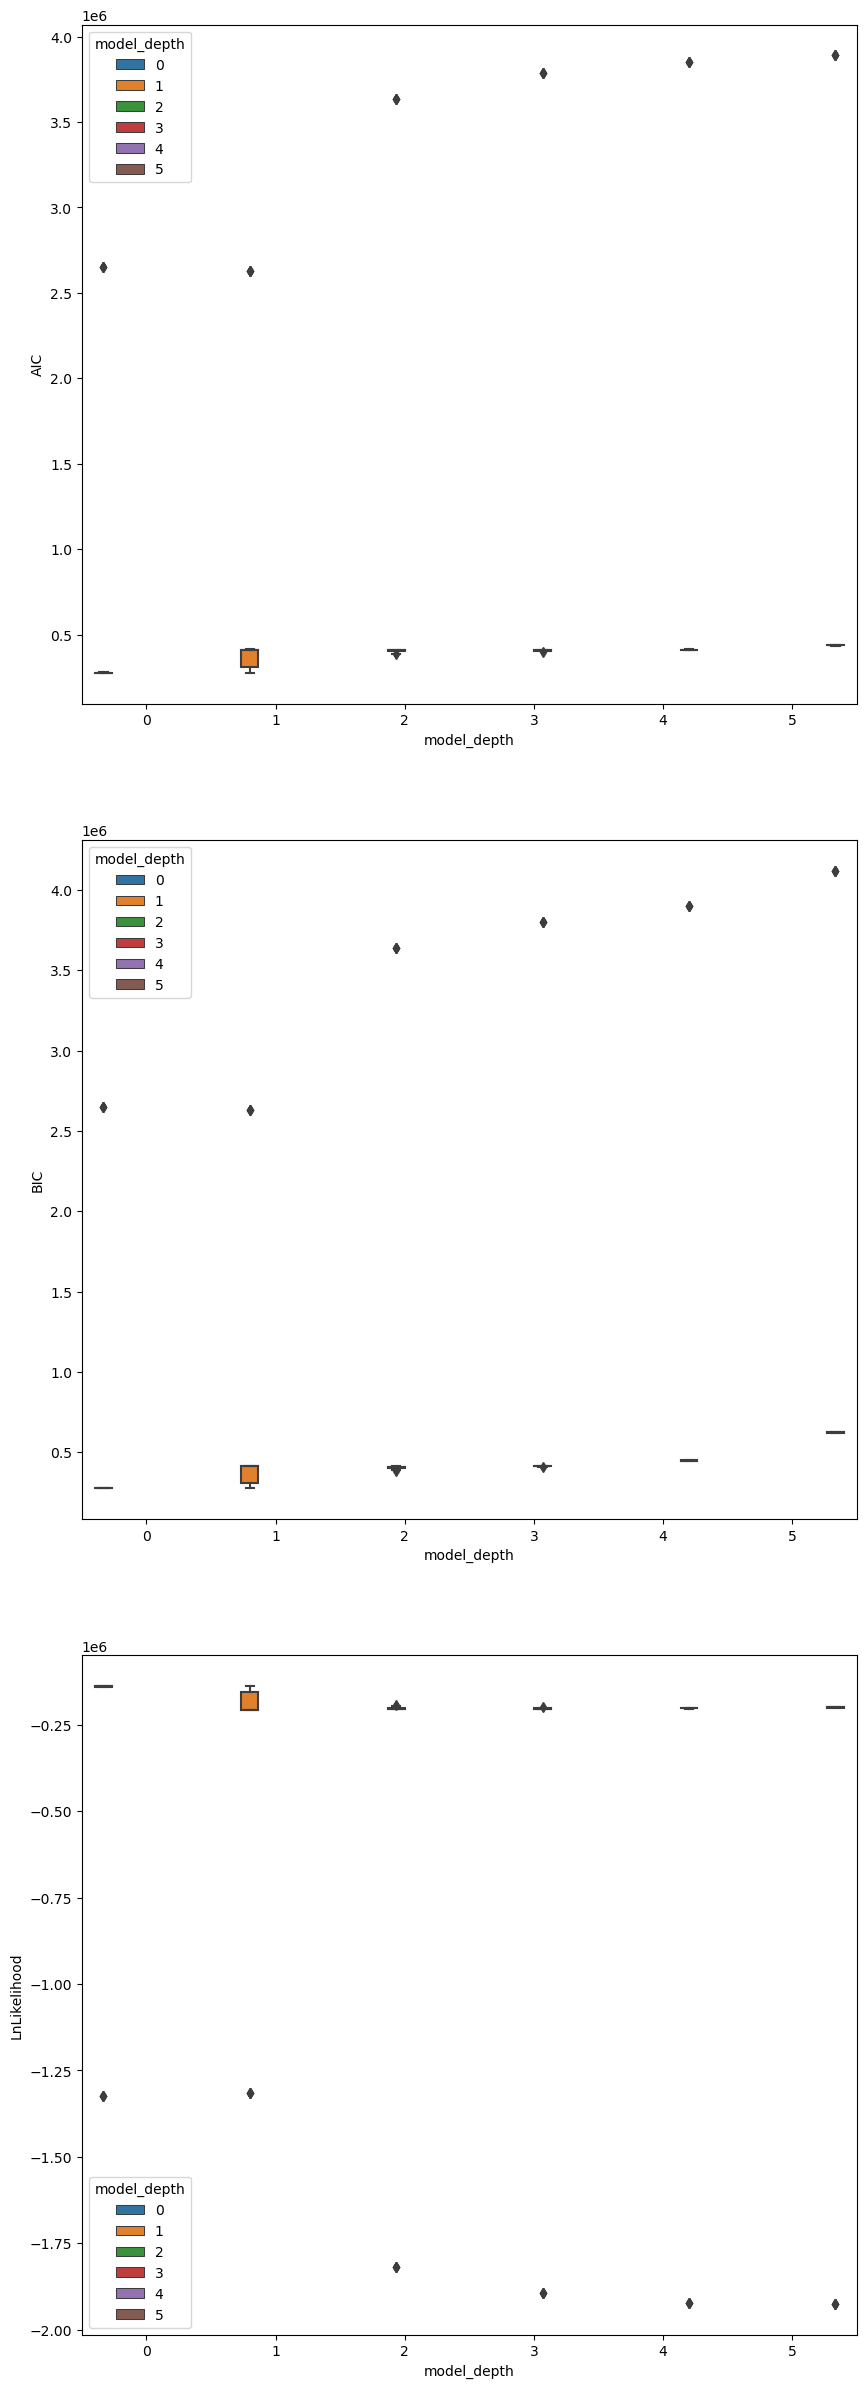

In [163]:
fig, ax = plt.subplots(3, 1, figsize = (10, 30))
sns.boxplot(data = table_pars, y = 'AIC', x = 'model_depth', hue = 'model_depth', ax = ax[0])
sns.boxplot(data = table_pars, y = 'BIC', hue = 'model_depth', x = 'model_depth', ax = ax[1])
sns.boxplot(data = table_pars, y = 'LnLikelihood', hue = 'model_depth', x = 'model_depth', ax = ax[2])

Табличка с паметрами подтверждает увиденное на боксплоте - легкие модели работат немного лучше (ну, по построению критерия в том числе))) - их и оставим - возьмем модели глубины 2 и 3

In [165]:
table_pars.sort_values(by = ['BIC'], ascending = True).iloc[:20, :]

,model_depth,AIC,BIC,LnLikelihood,GC_context,N_context
61,1,275389.000293,275674.387757,-137664.500146,50621,300
169,1,275757.048582,276042.436046,-137848.524291,50552,200
73,1,275898.198852,276183.586316,-137919.099426,50439,200
156,0,276851.552617,276899.117244,-138420.776309,47244,0
43,1,276642.524980,276927.912444,-138291.262490,49388,100
36,0,276893.003791,276940.568418,-138441.501896,47340,0
103,1,276701.562173,276986.949637,-138320.781086,51089,100
139,1,276786.082818,277071.470282,-138363.041409,50023,100
0,0,277057.338550,277104.903178,-138523.669275,51318,0
48,0,277073.666183,277121.230810,-138531.833091,51747,0


 самое время строить распределение правдоподобия - а для полного счастья построю его же на археях (как на совсем других ребятах, с другими частотами к-меров и с другими механизмами регуляции)

In [166]:
good_index = {61: 1, 156: 0}

In [172]:
for rec in SeqIO.parse(o_to_name['Cuniculiplasma divulgatum (archaea)'], 'fasta'):
    genome_arch = rec.seq
    break

ctrs = (int(random.random()*len(genome)) for i in range(1000))
new_parts_coli = cut_genome(ctrs, size = 1000)
ctrs = (int(random.random()*len(genome_arch)) for i in range(1000))
new_parts_arch = cut_genome(ctrs, size = 1000, genome = genome_arch)

In [173]:
preds = {'depth': [], 'organism': [], 'lnlikelihood': []}
for q in tqdm_notebook(new_parts_coli, desc="Make preds coli", total = 1000):
    for m in good_index.keys():
        ll = models[m].predict_prob(q)
        preds['depth'].append(good_index[m])
        preds['organism'].append('E. coli')
        preds['lnlikelihood'].append(ll)
        
for q in tqdm_notebook(new_parts_arch, desc="Make preds Cuniculiplasma", total = 1000):
    for m in good_index.keys():
        ll = models[m].predict_prob(q)
        preds['depth'].append(good_index[m])
        preds['organism'].append('Cuniculiplasma divulgatum')
        preds['lnlikelihood'].append(ll)

Make preds coli:   0%|          | 0/1000 [00:00<?, ?it/s]

Make preds Cuniculiplasma:   0%|          | 0/1000 [00:00<?, ?it/s]

In [175]:
preds = pd.DataFrame(preds)

In [176]:
preds

,depth,organism,lnlikelihood
0,1,E. coli,-138235.835609
1,0,E. coli,-138679.563277
2,1,E. coli,-137966.631020
3,0,E. coli,-138879.424783
4,1,E. coli,-138029.297270
...,...,...,...
3995,0,Cuniculiplasma divulgatum,-137464.958962
3996,1,Cuniculiplasma divulgatum,-139297.967507
3997,0,Cuniculiplasma divulgatum,-137431.356043
3998,1,Cuniculiplasma divulgatum,-139021.129575


с распределением логарифма правдоподобия все сложно - оно сжалось до палки. Заметно, что у эшерихии большее число учатков имеют высокое правдоподобие - что неудивительно, на ней же смотрели к-меры. Модели глубины один показывают себя лучше - что тоже неудивительно, больше знают))) Можно попробовать улучшить показания моделей просто аккуратно убрав энки.

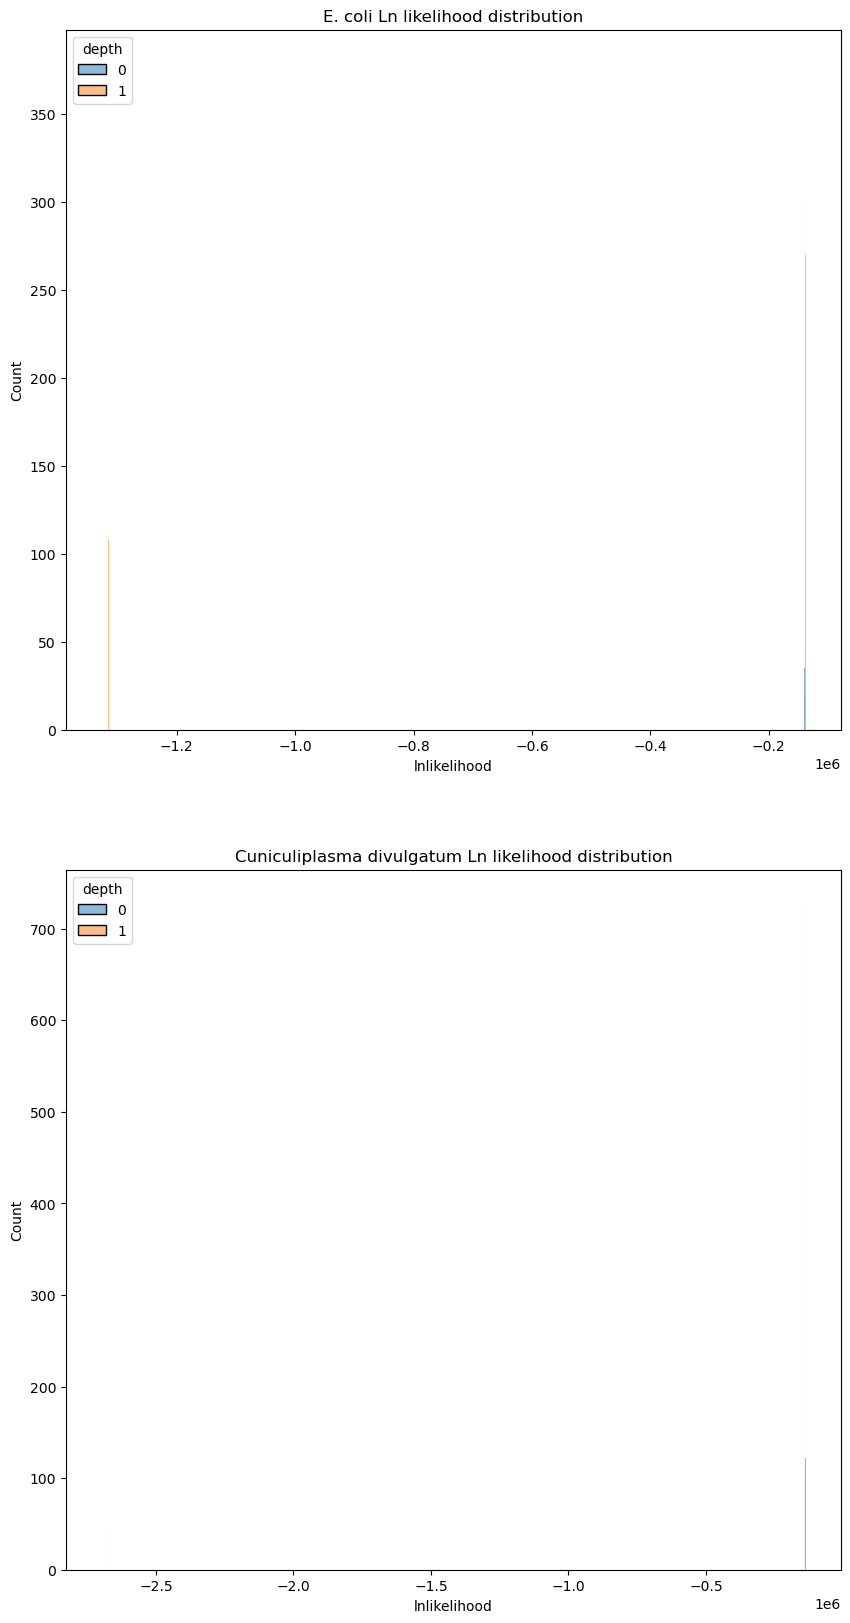

In [185]:
fig, ax = plt.subplots(2, 1, figsize = (10, 20))
sns.histplot(data = preds[preds.organism == 'E. coli'], 
             x = 'lnlikelihood', 
             hue = 'depth', ax = ax[0])
ax[0].set_title('E. coli Ln likelihood distribution')
sns.histplot(data = preds[preds.organism == 'Cuniculiplasma divulgatum'], 
             x = 'lnlikelihood', 
             hue = 'depth', ax = ax[1])
ax[1].set_title('Cuniculiplasma divulgatum Ln likelihood distribution')

plt.show()